# Marmousi

From the official [tutorial](https://mondaic.com/docs/tutorials/exploration/marmousi_2d/marmousi_2d).

In [1]:
%matplotlib inline
%config Completer.use_jedi = False

import wget
import shutil
from pathlib import Path
from typing import List

import scipy
import obspy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from salvus.flow import api
from salvus.flow import simple_config as config

from salvus_toolbox import toolbox

In [2]:
# Download Marmousi model ~150 MB.
url = (
    "https://s3.amazonaws.com/open.source.geoscience/open_data"
    "/elastic-marmousi/elastic-marmousi-model.tar.gz"
)
if not Path("elastic-marmousi-model.tar.gz").exists():
    shutil.unpack_archive(wget.download(url))

In [3]:
# Read marmousi model.
model_directory = Path("./elastic-marmousi-model/model")
marmousi_model = toolbox.read_elastic_marmousi(model_directory, ["VP", "RHO"])

/work/bfilippo/Salvus_toolbox/salvus_toolbox/toolbox.py:746: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  t.data[::decimate] for t in stream.traces[::decimate]


In [4]:
marmousi_model

<xarray.Dataset>
Dimensions:  (x: 1361, y: 281)
Coordinates:
  * x        (x) float64 0.0 12.5 25.0 37.5 ... 1.698e+04 1.699e+04 1.7e+04
  * y        (y) float64 3.5e+03 3.488e+03 3.475e+03 3.462e+03 ... 25.0 12.5 0.0
Data variables:
    VP       (y, x) float32 1500.0 1500.0 1500.0 1500.0 ... 3800.0 3800.0 3800.0
    RHO      (y, x) float32 1010.0 1010.0 1010.0 1010.0 ... 2483.0 2483.0 2483.0

In [5]:
marmousi_model['VP'].data.shape

(281, 1361)

In [6]:
marmousi_model['VP'].data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [7]:
marmousi_model['VP'][2][0].data.__array_interface__['data']

(93906324276120, False)

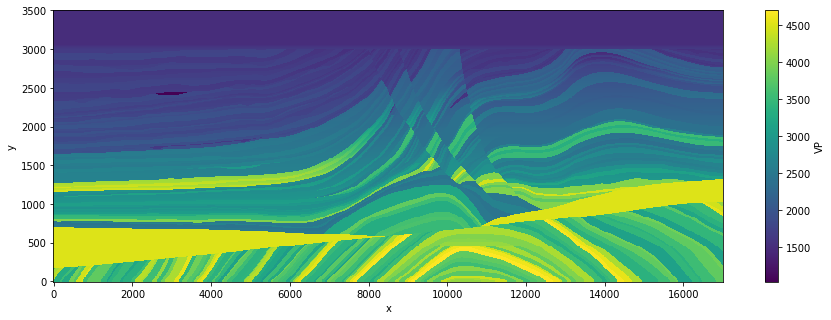

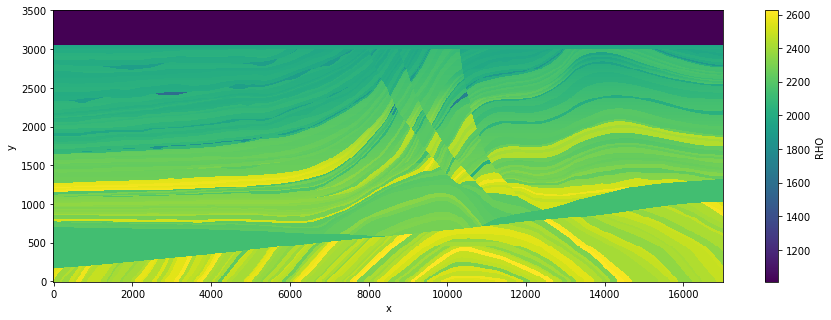

In [8]:
marmousi_model["VP"].plot(aspect="auto", figsize=(15, 5))
plt.show()
marmousi_model["RHO"].plot(aspect="auto", figsize=(15, 5))
plt.show()

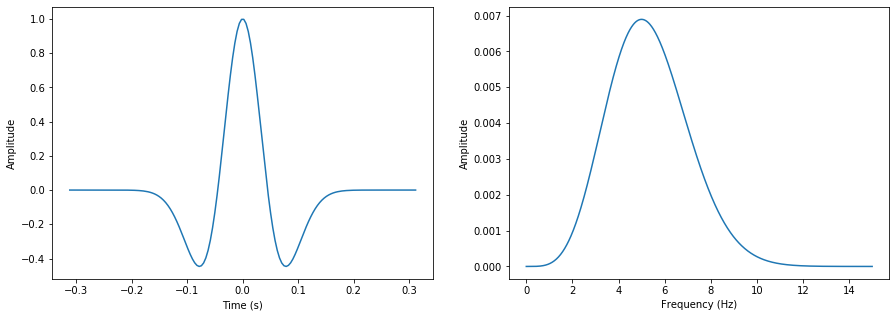

In [9]:
wavelet = config.stf.Ricker(center_frequency=5.0)

f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(*wavelet.get_stf())
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")

ax[1].plot(*wavelet.get_power_spectrum())
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude")

plt.show()

In [10]:
num_absorbing_layers = 10
absorbing_side_sets = ["x0", "x1", "y0"]

In [11]:
mesh_frequency = 2 * wavelet.center_frequency
salvus_mesh = toolbox.mesh_from_xarray(
    model_order=4,
    data=marmousi_model,
    slowest_velocity="VP",
    maximum_frequency=mesh_frequency,
    elements_per_wavelength=1.5,
    absorbing_boundaries=(absorbing_side_sets, num_absorbing_layers),
)

In [12]:
salvus_mesh

In [18]:
source = config.source.cartesian.ScalarPoint2D(
    source_time_function=wavelet, x=8500.0, y=3490.0, f=1
)

In [19]:
receivers = config.receiver.cartesian.SideSetHorizontalPointCollection2D(
    x=np.linspace(0.0, 17000.0, 1000),
    offset=-10.0,
    station_code="xx",
    side_set_name="y1",
    fields=["phi", "gradient-of-phi"],
)

In [20]:
s = config.simulation.Waveform(
    mesh=salvus_mesh, sources=source, receivers=receivers
)

In [21]:
# Leave start time and time step as their auto-detected defaults.
# s.physics.wave_equation.start_time_in_seconds = ?
# s.physics.wave_equation.time_step_in_seconds = ?

# Set end time.
s.physics.wave_equation.end_time_in_seconds = 8.0

In [22]:
# Define Dirichlet boundary at top surface (pressure-free).
dirichlet = config.boundary.HomogeneousDirichlet(side_sets=["y1"])

# Define coupled Clayton-Enqist / Kosloff
# damping boundaries at the the remaining side-sets.
absorbing = config.boundary.Absorbing(
    width_in_meters=685.333,
    side_sets=["x0", "y0", "x1"],
    taper_amplitude=wavelet.center_frequency,
)

# Add the boundaries to the parameter file.
s.physics.wave_equation.boundaries = [absorbing, dirichlet]

In [23]:
s.output.point_data.format = "hdf5"

In [24]:
# s.output.volume_data.format = "hdf5"
# s.output.volume_data.filename = "output.h5"
# s.output.volume_data.fields = ["phi", "gradient-of-phi"]
# s.output.volume_data.sampling_interval_in_time_steps = 100

In [25]:
s.validate()

In [26]:
api.run(
    input_file=s,
    ranks=2,
    site_name="aug04",
    get_all=True,
    output_folder="output",
    overwrite=True,
)

Job `job_2002171756513061_5d5eba78bc` running on `aug04` with 2 rank(s).
Site information:
  * Salvus version: 0.11.0-beta.1-853-g28a5ee38
  * Floating point size: 32



* Downloaded 66.6 MB of results to `output`.
* Total run time: 59.90 seconds.
* Pure simulation time: 56.80 seconds.


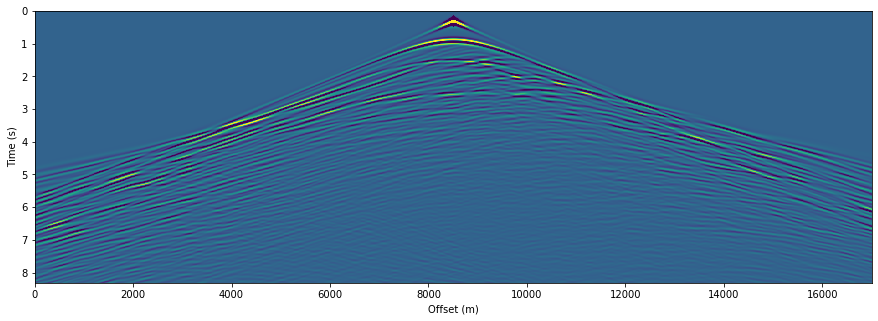

In [27]:
# Generate a shotgather from and HDF5 receiver file.
data, dt, extent = toolbox.get_shotgather("output/receivers.h5", field="phi")

# Normalize and plot the shotgather.
clip_min = 0.01 * data.min()
clip_max = 0.01 * data.max()
f = plt.figure(figsize=(15, 5))
plt.imshow(data, vmin=clip_min, vmax=clip_max, extent=extent, aspect="auto")

plt.xlabel("Offset (m)")
plt.ylabel("Time (s)")
plt.show()

In [28]:
data.shape

(5774, 1000)

In [29]:
import h5py

In [30]:
f5 = h5py.File("output/receivers.h5", mode='r')

In [31]:
for i in f5.keys():
    print(f5[i])

<HDF5 dataset "coordinates_ACOUSTIC_point": shape (1000, 2), type "<f8">
<HDF5 dataset "names_ACOUSTIC_point": shape (1000,), type "|O">
<HDF5 group "/point" (2 members)>
<HDF5 dataset "receiver_ids_ACOUSTIC_point": shape (1000,), type "<i8">


In [32]:
for i in f5['point'].attrs:
    print(i)

sampling_interval_in_time_steps
sampling_rate_in_hertz
sampling_rate_in_hz
start_time_in_seconds
